In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Подготовка данных от Сергея

In [2]:
data = pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep=';')

In [3]:
data['time_start'] = pd.to_datetime(data['time_start'])
data['time_end'] = pd.to_datetime(data['time_end'])

In [4]:
data['duration'] = data['time_end'] - data['time_start']
data['min']= data['duration'].dt.seconds/60

In [5]:
data_target = data['min'].copy()

In [6]:
low, up = np.percentile(data['min'].values, [1 , 95]) 

bad_index = list(data[data['min'].values > up].index)

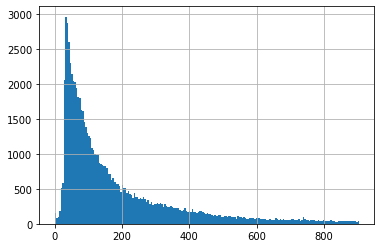

In [7]:
data['min'].drop(index=bad_index).hist(bins=200)

In [8]:
data.drop(index=bad_index, inplace=True)
data.index = range(data.shape[0])

## MeanShift

In [9]:
from sklearn.cluster import MeanShift

In [10]:
new_data = data[['place_latitude', 'place_longitude']].copy()

In [11]:
%%time

clustering = MeanShift(bandwidth = 0.1, n_jobs=-1).fit(new_data)

Wall time: 6min


In [12]:
len(np.unique(clustering.predict(new_data)))

518

In [13]:
new_data['class'] = clustering.predict(new_data)

In [14]:
data['class'] = new_data['class']

In [15]:
data_for_time_series = data[['time_start', 'min']][data['class'] == 58].copy()

In [16]:
data_for_time_series = data_for_time_series.iloc[:, :4]

## Time series для одного кластера


In [17]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression

In [18]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [19]:
data_for_time_series.index = data_for_time_series['time_start']
data_for_time_series["year"] = data_for_time_series.index.year
data_for_time_series["month"] = data_for_time_series.index.month
data_for_time_series["weekday"] = data_for_time_series.index.weekday
data_for_time_series["hour"] = data_for_time_series.index.hour
data_for_time_series["minute"] = data_for_time_series.index.minute
#data_for_time_series['is_weekend'] = data_for_time_series.weekday.isin([5,6])*1
data_for_time_series.drop(labels=['time_start'], inplace=True, axis=1)
data_for_time_series.head()

,min,year,month,weekday,hour,minute
time_start,,,,,,
2019-08-24 14:23:56,270.850000,2019,8,5,14,23
2018-06-19 08:56:22,199.066667,2018,6,1,8,56
2018-08-29 14:00:32,37.316667,2018,8,2,14,0
2019-12-10 16:01:26,33.933333,2019,12,1,16,1
2018-08-07 20:36:49,72.900000,2018,8,1,20,36


In [20]:
code_mean(data_for_time_series, 'weekday', 'min')

{0: 215.42863247863244,
 1: 139.52840909090912,
 2: 172.64549549549548,
 3: 157.1650326797386,
 4: 186.56399999999994,
 5: 228.80040650406505,
 6: 206.1229166666666}

In [21]:
def prepareData(data, test_size):

    test_index = int(len(data)*(1-test_size))

    data.drop(['year', 'month', 'weekday', 'hour', 'minute'], axis=1, inplace=True)
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    data = data.sort_index()

    x_train = data.loc[:test_index]['min']
    x_test = data.loc[test_index:]['min']
    
    x_test = x_test.reset_index()

    return x_train, x_test

In [22]:
x_train, x_test = prepareData(data_for_time_series, test_size=0.3)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [24]:
window_size = 20
batch_size=32
test_size = 0.3
test_index = int(len(data_for_time_series)*(1-test_size))
def make_datasets(series, batch_size=32, window_size=20):
    shuffle_buffer_size = 1000
    train_dataset = tf.data.Dataset.from_tensor_slices(series)
    train_dataset = train_dataset.window(window_size + 1, shift=1, drop_remainder=True)
    train_dataset = train_dataset.flat_map(lambda window: window.batch(window_size + 1))
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    train_dataset = train_dataset.batch(batch_size).prefetch(1)
    return train_dataset

In [25]:
def mape(y_true, predicted):
    return np.mean(np.abs(y_true - np.ravel(predicted)) / y_true)

In [26]:
def make_prediction(model, data_for_time_series, window_size, test_index, x_test):
    
    forecast = []

    for time in range(len(data_for_time_series) - window_size):
        forecast.append(model.predict(data_for_time_series[time:time + window_size].T))


    forecast = forecast[test_index - window_size:]
    results = np.array(forecast)[:, 0]


    plt.figure(figsize=(10, 6))

    plt.plot(x_test, label='true')
    plt.plot(results, label='predicted')
    plt.title('MAPE: {}'.format(mape(x_test.values, results)))
    plt.legend()

# Пробуем обычную нейронную сеть

In [35]:
x_test = x_test.drop(columns=['index'])

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [37]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train)
test_dataset = make_datasets(x_test)

model = Sequential([Dense(32, input_shape=[20], activation='relu'), 
                   Dense(16, activation='relu'),
                   Dense(8, activation='relu'),
                   Dense(4, activation='relu'),
                   Dense(1)])

optimizer = tf.keras.optimizers.Adam()

In [38]:
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer=optimizer)

In [39]:
hist = model.fit(train_dataset, epochs=500)

Train on None steps
Epoch 1/500
6/6 [==============================]ss: 118.34 - 0s 112ms/step - loss: 200.18 - 0s 78ms/step - loss: 188.6283 - 0s 60ms/step - loss: 176.383 - 0s 49ms/step - loss: 160.261 - 0s 42ms/step - loss: 152.656 - 0s 44ms/step - loss: 152.6569
Epoch 2/500
6/6 [==============================] - ETA: 0s - loss: 108.502 - 0s 9ms/step - loss: 118.0487
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 103.571 - 0s 8ms/step - loss: 97.0085
Epoch 4/500
6/6 [==============================] - ETA: 0s - loss: 106.990 - 0s 7ms/step - loss: 82.6429
Epoch 5/500
6/6 [==============================] - ETA: 0s - loss: 60.85 - 0s 9ms/step - loss: 75.9703
Epoch 6/500
6/6 [==============================] - ETA: 0s - loss: 92.89 - 0s 8ms/step - loss: 71.7816
Epoch 7/500
6/6 [==============================] - ETA: 0s - loss: 67.55 - 0s 7ms/step - loss: 68.8158
Epoch 8/500
6/6 [==============================] - ETA: 0s - loss: 63.88 - 0s 9ms/step - loss: 67.9162
Epoch

Epoch 78/500
6/6 [==============================] - ETA: 0s - loss: 31.23 - 0s 9ms/step - loss: 39.5973
Epoch 79/500
6/6 [==============================] - ETA: 0s - loss: 43.95 - 0s 8ms/step - loss: 39.9044
Epoch 80/500
6/6 [==============================] - ETA: 0s - loss: 36.87 - 0s 8ms/step - loss: 40.1120
Epoch 81/500
6/6 [==============================] - ETA: 0s - loss: 49.23 - 0s 9ms/step - loss: 39.3180
Epoch 82/500
6/6 [==============================] - ETA: 0s - loss: 39.64 - 0s 8ms/step - loss: 39.5651
Epoch 83/500
6/6 [==============================] - ETA: 0s - loss: 44.43 - 0s 9ms/step - loss: 39.8939
Epoch 84/500
6/6 [==============================] - ETA: 0s - loss: 41.86 - 0s 12ms/step - loss: 39.8550
Epoch 85/500
6/6 [==============================] - ETA: 0s - loss: 37.79 - 0s 17ms/step - loss: 41.0855
Epoch 86/500
6/6 [==============================] - ETA: 0s - loss: 43.53 - 0s 14ms/step - loss: 39.6817
Epoch 87/500
6/6 [==============================] - ETA: 0s -

Epoch 156/500
6/6 [==============================] - ETA: 0s - loss: 24.73 - 0s 15ms/step - loss: 31.4809
Epoch 157/500
6/6 [==============================] - ETA: 0s - loss: 36.75 - 0s 9ms/step - loss: 30.8324
Epoch 158/500
6/6 [==============================] - ETA: 0s - loss: 23.16 - 0s 9ms/step - loss: 31.9803
Epoch 159/500
6/6 [==============================] - ETA: 0s - loss: 32.23 - 0s 16ms/step - loss: 33.5055
Epoch 160/500
6/6 [==============================] - ETA: 0s - loss: 22.15 - 0s 18ms/step - loss: 31.8041
Epoch 161/500
6/6 [==============================] - ETA: 0s - loss: 27.80 - 0s 17ms/step - loss: 30.5750
Epoch 162/500
6/6 [==============================] - ETA: 0s - loss: 29.73 - 0s 22ms/step - loss: 31.1603
Epoch 163/500
6/6 [==============================] - ETA: 0s - loss: 24.09 - 0s 17ms/step - loss: 32.8512
Epoch 164/500
6/6 [==============================] - ETA: 0s - loss: 31.90 - 0s 17ms/step - loss: 32.7037
Epoch 165/500
6/6 [=============================

6/6 [==============================] - ETA: 0s - loss: 27.85 - 0s 9ms/step - loss: 24.6529
Epoch 234/500
6/6 [==============================] - ETA: 0s - loss: 28.86 - 0s 10ms/step - loss: 24.9855
Epoch 235/500
6/6 [==============================] - ETA: 0s - loss: 22.57 - 0s 8ms/step - loss: 25.1803
Epoch 236/500
6/6 [==============================] - ETA: 0s - loss: 29.34 - 0s 9ms/step - loss: 25.0755
Epoch 237/500
6/6 [==============================] - ETA: 0s - loss: 20.30 - 0s 7ms/step - loss: 25.0921
Epoch 238/500
6/6 [==============================] - ETA: 0s - loss: 24.18 - 0s 8ms/step - loss: 25.0762
Epoch 239/500
6/6 [==============================] - ETA: 0s - loss: 19.13 - 0s 8ms/step - loss: 25.4724
Epoch 240/500
6/6 [==============================] - ETA: 0s - loss: 30.60 - 0s 8ms/step - loss: 25.2252
Epoch 241/500
6/6 [==============================] - ETA: 0s - loss: 29.29 - 0s 7ms/step - loss: 26.8236
Epoch 242/500
6/6 [==============================] - ETA: 0s - loss:

Epoch 311/500
6/6 [==============================] - ETA: 0s - loss: 21.42 - 0s 13ms/step - loss: 21.6019
Epoch 312/500
6/6 [==============================] - ETA: 0s - loss: 17.44 - ETA: 0s - loss: 20.29 - 0s 20ms/step - loss: 20.6877
Epoch 313/500
6/6 [==============================] - ETA: 0s - loss: 23.64 - 0s 16ms/step - loss: 21.0088
Epoch 314/500
6/6 [==============================] - ETA: 0s - loss: 16.95 - 0s 14ms/step - loss: 21.8626
Epoch 315/500
6/6 [==============================] - ETA: 0s - loss: 33.19 - 0s 13ms/step - loss: 22.3753
Epoch 316/500
6/6 [==============================] - ETA: 0s - loss: 18.04 - 0s 15ms/step - loss: 21.6388
Epoch 317/500
6/6 [==============================] - ETA: 0s - loss: 15.47 - 0s 14ms/step - loss: 21.0518
Epoch 318/500
6/6 [==============================] - ETA: 0s - loss: 23.63 - 0s 15ms/step - loss: 21.5918
Epoch 319/500
6/6 [==============================] - ETA: 0s - loss: 16.96 - 0s 16ms/step - loss: 21.7386
Epoch 320/500
6/6 [===

Epoch 388/500
6/6 [==============================] - ETA: 0s - loss: 16.70 - 0s 9ms/step - loss: 20.1242
Epoch 389/500
6/6 [==============================] - ETA: 0s - loss: 21.53 - 0s 9ms/step - loss: 21.1755
Epoch 390/500
6/6 [==============================] - ETA: 0s - loss: 22.41 - 0s 8ms/step - loss: 21.7204
Epoch 391/500
6/6 [==============================] - ETA: 0s - loss: 23.36 - 0s 9ms/step - loss: 22.8895
Epoch 392/500
6/6 [==============================] - ETA: 0s - loss: 20.13 - 0s 10ms/step - loss: 23.7782
Epoch 393/500
6/6 [==============================] - ETA: 0s - loss: 19.03 - 0s 8ms/step - loss: 23.0699
Epoch 394/500
6/6 [==============================] - ETA: 0s - loss: 18.26 - 0s 7ms/step - loss: 20.9281
Epoch 395/500
6/6 [==============================] - ETA: 0s - loss: 12.18 - 0s 16ms/step - loss: 20.3875
Epoch 396/500
6/6 [==============================] - ETA: 0s - loss: 18.07 - 0s 15ms/step - loss: 20.3371
Epoch 397/500
6/6 [==============================] -

Epoch 465/500
6/6 [==============================] - ETA: 0s - loss: 21.88 - 0s 14ms/step - loss: 17.7013
Epoch 466/500
6/6 [==============================] - ETA: 0s - loss: 8.715 - 0s 12ms/step - loss: 18.0742
Epoch 467/500
6/6 [==============================] - ETA: 0s - loss: 22.90 - 0s 13ms/step - loss: 18.7687
Epoch 468/500
6/6 [==============================] - ETA: 0s - loss: 9.986 - 0s 13ms/step - loss: 17.9384
Epoch 469/500
6/6 [==============================] - ETA: 0s - loss: 14.89 - 0s 16ms/step - loss: 17.4806
Epoch 470/500
6/6 [==============================] - ETA: 0s - loss: 16.68 - 0s 11ms/step - loss: 17.4339
Epoch 471/500
6/6 [==============================] - ETA: 0s - loss: 14.08 - 0s 14ms/step - loss: 17.8697
Epoch 472/500
6/6 [==============================] - ETA: 0s - loss: 15.22 - 0s 12ms/step - loss: 18.0582
Epoch 473/500
6/6 [==============================] - ETA: 0s - loss: 23.49 - 0s 11ms/step - loss: 18.2258
Epoch 474/500
6/6 [===========================

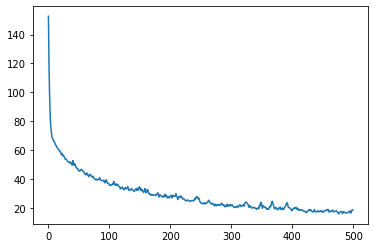

In [40]:
plt.plot(hist.history['loss'])

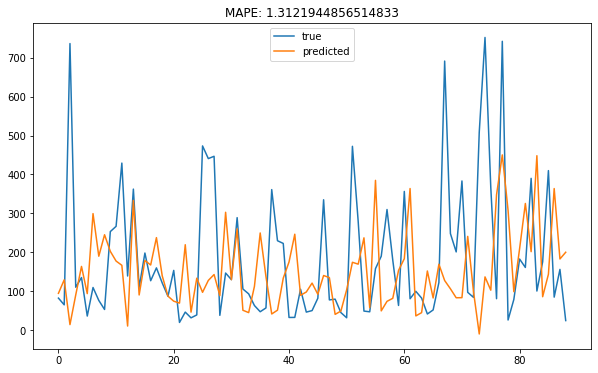

In [41]:
make_prediction(model, data_for_time_series, window_size, test_index, x_test)

# Пробуем RNN

In [42]:
from tensorflow.keras.layers import SimpleRNN, Lambda
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [88]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train, batch_size=128, window_size=30)
test_dataset = make_datasets(x_test, batch_size=128, window_size=30)

rnn = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                         SimpleRNN(32, return_sequences=True),
                         SimpleRNN(16),
                         Dense(8, activation='relu'),
                         Dense(1), 
                         Lambda(lambda x : x * 500.0)])

optimizer = tf.keras.optimizers.Adam()
rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

In [89]:
history = rnn.fit(train_dataset, epochs=500)

Train on None steps
Epoch 1/500
2/2 [==============================]ss: 82.048 - 1s 327ms/step - loss: 80.718 - 1s 331ms/step - loss: 80.7188
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 65.53 - 0s 47ms/step - loss: 63.1723
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 66.26 - 0s 35ms/step - loss: 70.2080
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 59.86 - 0s 32ms/step - loss: 63.9600
Epoch 5/500
2/2 [==============================] - ETA: 0s - loss: 64.41 - 0s 35ms/step - loss: 68.2467
Epoch 6/500
2/2 [==============================] - ETA: 0s - loss: 65.01 - 0s 33ms/step - loss: 62.0459
Epoch 7/500
2/2 [==============================] - ETA: 0s - loss: 60.50 - 0s 33ms/step - loss: 63.2580
Epoch 8/500
2/2 [==============================] - ETA: 0s - loss: 64.76 - 0s 33ms/step - loss: 62.6745
Epoch 9/500
2/2 [==============================] - ETA: 0s - loss: 62.52 - 0s 33ms/step - loss: 62.2590
Epoch 10/500
2/2 [========

Epoch 79/500
2/2 [==============================] - ETA: 0s - loss: 58.37 - 0s 50ms/step - loss: 59.6160
Epoch 80/500
2/2 [==============================] - ETA: 0s - loss: 59.89 - 0s 58ms/step - loss: 58.2430
Epoch 81/500
2/2 [==============================] - ETA: 0s - loss: 59.80 - 0s 52ms/step - loss: 58.7020
Epoch 82/500
2/2 [==============================] - ETA: 0s - loss: 55.24 - 0s 52ms/step - loss: 62.5695
Epoch 83/500
2/2 [==============================] - ETA: 0s - loss: 59.10 - 0s 93ms/step - loss: 59.6053
Epoch 84/500
2/2 [==============================] - ETA: 0s - loss: 58.25 - 0s 86ms/step - loss: 59.2619
Epoch 85/500
2/2 [==============================] - ETA: 0s - loss: 58.58 - 0s 79ms/step - loss: 59.0800
Epoch 86/500
2/2 [==============================] - ETA: 0s - loss: 58.62 - 0s 82ms/step - loss: 59.1828
Epoch 87/500
2/2 [==============================] - ETA: 0s - loss: 59.60 - 0s 59ms/step - loss: 58.6898
Epoch 88/500
2/2 [==============================] - ETA

2/2 [==============================] - ETA: 0s - loss: 57.40 - 0s 51ms/step - loss: 57.9634
Epoch 157/500
2/2 [==============================] - ETA: 0s - loss: 60.20 - 0s 50ms/step - loss: 56.0046
Epoch 158/500
2/2 [==============================] - ETA: 0s - loss: 57.86 - 0s 51ms/step - loss: 57.0721
Epoch 159/500
2/2 [==============================] - ETA: 0s - loss: 59.70 - 0s 44ms/step - loss: 57.5157
Epoch 160/500
2/2 [==============================] - ETA: 0s - loss: 57.95 - 0s 45ms/step - loss: 57.7111
Epoch 161/500
2/2 [==============================] - ETA: 0s - loss: 59.71 - 0s 46ms/step - loss: 56.4084
Epoch 162/500
2/2 [==============================] - ETA: 0s - loss: 56.98 - 0s 50ms/step - loss: 57.5383
Epoch 163/500
2/2 [==============================] - ETA: 0s - loss: 59.90 - 0s 45ms/step - loss: 56.8588
Epoch 164/500
2/2 [==============================] - ETA: 0s - loss: 58.32 - 0s 54ms/step - loss: 56.5706
Epoch 165/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 54.55 - 0s 32ms/step - loss: 57.3118
Epoch 234/500
2/2 [==============================] - ETA: 0s - loss: 55.12 - 0s 33ms/step - loss: 56.6289
Epoch 235/500
2/2 [==============================] - ETA: 0s - loss: 56.82 - 0s 31ms/step - loss: 54.6083
Epoch 236/500
2/2 [==============================] - ETA: 0s - loss: 53.89 - 0s 33ms/step - loss: 56.7818
Epoch 237/500
2/2 [==============================] - ETA: 0s - loss: 54.92 - 0s 31ms/step - loss: 56.2889
Epoch 238/500
2/2 [==============================] - ETA: 0s - loss: 52.95 - 0s 32ms/step - loss: 57.2043
Epoch 239/500
2/2 [==============================] - ETA: 0s - loss: 54.42 - 0s 29ms/step - loss: 58.0888
Epoch 240/500
2/2 [==============================] - ETA: 0s - loss: 54.39 - 0s 42ms/step - loss: 55.8686
Epoch 241/500
2/2 [==============================] - ETA: 0s - loss: 55.33 - 0s 51ms/step - loss: 59.1644
Epoch 242/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 58.05 - 0s 35ms/step - loss: 55.1680
Epoch 311/500
2/2 [==============================] - ETA: 0s - loss: 55.39 - 0s 33ms/step - loss: 54.5027
Epoch 312/500
2/2 [==============================] - ETA: 0s - loss: 51.77 - 0s 37ms/step - loss: 59.0219
Epoch 313/500
2/2 [==============================] - ETA: 0s - loss: 54.41 - 0s 49ms/step - loss: 55.4236
Epoch 314/500
2/2 [==============================] - ETA: 0s - loss: 55.85 - 0s 32ms/step - loss: 57.2316
Epoch 315/500
2/2 [==============================] - ETA: 0s - loss: 56.35 - 0s 31ms/step - loss: 56.9782
Epoch 316/500
2/2 [==============================] - ETA: 0s - loss: 55.23 - 0s 35ms/step - loss: 54.7871
Epoch 317/500
2/2 [==============================] - ETA: 0s - loss: 53.77 - 0s 32ms/step - loss: 55.6023
Epoch 318/500
2/2 [==============================] - ETA: 0s - loss: 55.17 - 0s 35ms/step - loss: 53.8526
Epoch 319/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 52.27 - 0s 40ms/step - loss: 54.0454
Epoch 388/500
2/2 [==============================] - ETA: 0s - loss: 50.97 - 0s 32ms/step - loss: 52.2035
Epoch 389/500
2/2 [==============================] - ETA: 0s - loss: 49.47 - 0s 34ms/step - loss: 55.7241
Epoch 390/500
2/2 [==============================] - ETA: 0s - loss: 52.50 - 0s 33ms/step - loss: 54.0128
Epoch 391/500
2/2 [==============================] - ETA: 0s - loss: 51.55 - 0s 33ms/step - loss: 53.9040
Epoch 392/500
2/2 [==============================] - ETA: 0s - loss: 53.05 - 0s 35ms/step - loss: 53.3920
Epoch 393/500
2/2 [==============================] - ETA: 0s - loss: 53.74 - 0s 33ms/step - loss: 50.2559
Epoch 394/500
2/2 [==============================] - ETA: 0s - loss: 56.61 - 0s 32ms/step - loss: 53.5584
Epoch 395/500
2/2 [==============================] - ETA: 0s - loss: 51.50 - 0s 32ms/step - loss: 53.2864
Epoch 396/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 50.91 - 0s 32ms/step - loss: 53.7722
Epoch 465/500
2/2 [==============================] - ETA: 0s - loss: 49.19 - 0s 32ms/step - loss: 51.8584
Epoch 466/500
2/2 [==============================] - ETA: 0s - loss: 54.56 - 0s 32ms/step - loss: 52.7867
Epoch 467/500
2/2 [==============================] - ETA: 0s - loss: 49.79 - 0s 30ms/step - loss: 52.4342
Epoch 468/500
2/2 [==============================] - ETA: 0s - loss: 57.16 - 0s 29ms/step - loss: 49.7711
Epoch 469/500
2/2 [==============================] - ETA: 0s - loss: 50.58 - 0s 32ms/step - loss: 54.8047
Epoch 470/500
2/2 [==============================] - ETA: 0s - loss: 52.61 - 0s 33ms/step - loss: 51.1937
Epoch 471/500
2/2 [==============================] - ETA: 0s - loss: 49.97 - 0s 31ms/step - loss: 51.3111
Epoch 472/500
2/2 [==============================] - ETA: 0s - loss: 51.90 - 0s 37ms/step - loss: 49.0773
Epoch 473/500
2/2 [==============================] - ETA: 0s

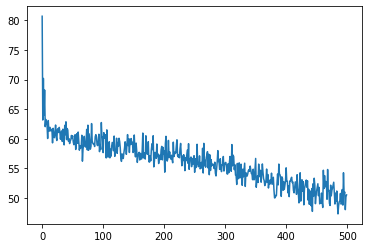

In [90]:
plt.plot(history.history['loss'])

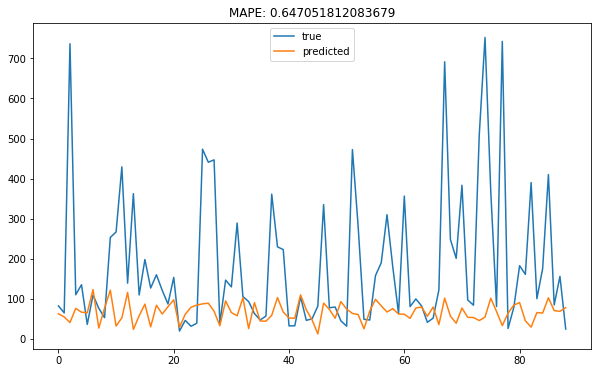

In [92]:
make_prediction(rnn, data_for_time_series, 30, test_index, x_test)

# Пробуем LSTM и Convolution

In [93]:
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, GRU

In [94]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train, batch_size=128, window_size=30)
test_dataset = make_datasets(x_test, batch_size=128, window_size=30)

lstm_conv = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                        Conv1D(filters=1, kernel_size=10, strides=1, padding="causal", activation="relu", 
                               input_shape=[None, 30]),
                    SimpleRNN(32, return_sequences=True),
                    SimpleRNN(16),
                    Dense(8, activation='relu'),
                    Dense(1), 
                    Lambda(lambda x : x * 500.0)
            
])


optimizer = tf.keras.optimizers.Adam()

lstm_conv.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

history = lstm_conv.fit(train_dataset, epochs=500)

Train on None steps
Epoch 1/500
2/2 [==============================]ss: 177.06 - 1s 304ms/step - loss: 165.66 - 1s 308ms/step - loss: 165.6686
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 137.581 - 0s 41ms/step - loss: 129.9780
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 103.020 - 0s 35ms/step - loss: 92.8526
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 71.49 - 0s 34ms/step - loss: 67.0677
Epoch 5/500
2/2 [==============================] - ETA: 0s - loss: 63.55 - 0s 42ms/step - loss: 66.5785
Epoch 6/500
2/2 [==============================] - ETA: 0s - loss: 73.07 - 0s 41ms/step - loss: 74.0256
Epoch 7/500
2/2 [==============================] - ETA: 0s - loss: 78.39 - 0s 34ms/step - loss: 80.4470
Epoch 8/500
2/2 [==============================] - ETA: 0s - loss: 77.31 - 0s 33ms/step - loss: 82.8171
Epoch 9/500
2/2 [==============================] - ETA: 0s - loss: 79.46 - 0s 32ms/step - loss: 76.2439
Epoch 10/500
2/2 [==

2/2 [==============================] - ETA: 0s - loss: 62.94 - 0s 37ms/step - loss: 61.6806
Epoch 79/500
2/2 [==============================] - ETA: 0s - loss: 62.10 - 0s 57ms/step - loss: 62.3277
Epoch 80/500
2/2 [==============================] - ETA: 0s - loss: 60.67 - 0s 68ms/step - loss: 63.3952
Epoch 81/500
2/2 [==============================] - ETA: 0s - loss: 60.49 - 0s 55ms/step - loss: 63.6151
Epoch 82/500
2/2 [==============================] - ETA: 0s - loss: 58.89 - 0s 33ms/step - loss: 64.7974
Epoch 83/500
2/2 [==============================] - ETA: 0s - loss: 59.85 - 0s 35ms/step - loss: 64.2499
Epoch 84/500
2/2 [==============================] - ETA: 0s - loss: 65.03 - 0s 34ms/step - loss: 59.7753
Epoch 85/500
2/2 [==============================] - ETA: 0s - loss: 59.76 - 0s 35ms/step - loss: 63.9618
Epoch 86/500
2/2 [==============================] - ETA: 0s - loss: 62.01 - 0s 55ms/step - loss: 61.9399
Epoch 87/500
2/2 [==============================] - ETA: 0s - loss: 

2/2 [==============================] - ETA: 0s - loss: 60.75 - 0s 37ms/step - loss: 60.1564
Epoch 156/500
2/2 [==============================] - ETA: 0s - loss: 62.01 - 0s 37ms/step - loss: 59.2565
Epoch 157/500
2/2 [==============================] - ETA: 0s - loss: 57.87 - 0s 34ms/step - loss: 62.3658
Epoch 158/500
2/2 [==============================] - ETA: 0s - loss: 59.80 - 0s 43ms/step - loss: 60.7980
Epoch 159/500
2/2 [==============================] - ETA: 0s - loss: 62.44 - 0s 41ms/step - loss: 58.4975
Epoch 160/500
2/2 [==============================] - ETA: 0s - loss: 61.59 - 0s 33ms/step - loss: 59.4331
Epoch 161/500
2/2 [==============================] - ETA: 0s - loss: 58.42 - 0s 37ms/step - loss: 61.8603
Epoch 162/500
2/2 [==============================] - ETA: 0s - loss: 60.15 - 0s 30ms/step - loss: 60.3864
Epoch 163/500
2/2 [==============================] - ETA: 0s - loss: 62.02 - 0s 39ms/step - loss: 58.9868
Epoch 164/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 60.27 - 0s 68ms/step - loss: 59.1147
Epoch 233/500
2/2 [==============================] - ETA: 0s - loss: 60.43 - 0s 67ms/step - loss: 59.9951
Epoch 234/500
2/2 [==============================] - ETA: 0s - loss: 60.86 - 0s 78ms/step - loss: 59.1742
Epoch 235/500
2/2 [==============================] - ETA: 0s - loss: 59.95 - 0s 92ms/step - loss: 58.8565
Epoch 236/500
2/2 [==============================] - ETA: 0s - loss: 61.78 - 0s 80ms/step - loss: 58.1742
Epoch 237/500
2/2 [==============================] - ETA: 0s - loss: 57.96 - 0s 81ms/step - loss: 60.6786
Epoch 238/500
2/2 [==============================] - ETA: 0s - loss: 58.20 - 0s 66ms/step - loss: 61.0786
Epoch 239/500
2/2 [==============================] - ETA: 0s - loss: 59.73 - 0s 81ms/step - loss: 59.8752
Epoch 240/500
2/2 [==============================] - ETA: 0s - loss: 59.55 - 0s 76ms/step - loss: 58.9726
Epoch 241/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 59.19 - 0s 35ms/step - loss: 59.0097
Epoch 310/500
2/2 [==============================] - ETA: 0s - loss: 62.04 - 0s 34ms/step - loss: 56.6431
Epoch 311/500
2/2 [==============================] - ETA: 0s - loss: 61.31 - 0s 35ms/step - loss: 58.8427
Epoch 312/500
2/2 [==============================] - ETA: 0s - loss: 57.74 - 0s 37ms/step - loss: 61.2830
Epoch 313/500
2/2 [==============================] - ETA: 0s - loss: 61.78 - 0s 33ms/step - loss: 56.9942
Epoch 314/500
2/2 [==============================] - ETA: 0s - loss: 58.93 - 0s 38ms/step - loss: 58.5987
Epoch 315/500
2/2 [==============================] - ETA: 0s - loss: 56.37 - 0s 35ms/step - loss: 60.7263
Epoch 316/500
2/2 [==============================] - ETA: 0s - loss: 57.80 - 0s 35ms/step - loss: 59.4836
Epoch 317/500
2/2 [==============================] - ETA: 0s - loss: 60.34 - 0s 33ms/step - loss: 57.2779
Epoch 318/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 58.38 - 0s 36ms/step - loss: 63.1942
Epoch 387/500
2/2 [==============================] - ETA: 0s - loss: 59.00 - 0s 34ms/step - loss: 60.4590
Epoch 388/500
2/2 [==============================] - ETA: 0s - loss: 58.51 - 0s 30ms/step - loss: 58.7410
Epoch 389/500
2/2 [==============================] - ETA: 0s - loss: 62.47 - 0s 31ms/step - loss: 57.8365
Epoch 390/500
2/2 [==============================] - ETA: 0s - loss: 58.43 - 0s 38ms/step - loss: 58.2454
Epoch 391/500
2/2 [==============================] - ETA: 0s - loss: 61.72 - 0s 36ms/step - loss: 57.5060
Epoch 392/500
2/2 [==============================] - ETA: 0s - loss: 62.40 - 0s 37ms/step - loss: 57.7717
Epoch 393/500
2/2 [==============================] - ETA: 0s - loss: 60.91 - 0s 36ms/step - loss: 57.3255
Epoch 394/500
2/2 [==============================] - ETA: 0s - loss: 56.43 - 0s 33ms/step - loss: 59.9845
Epoch 395/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 55.10 - 0s 65ms/step - loss: 59.6482
Epoch 464/500
2/2 [==============================] - ETA: 0s - loss: 58.59 - 0s 54ms/step - loss: 56.5610
Epoch 465/500
2/2 [==============================] - ETA: 0s - loss: 58.35 - 0s 55ms/step - loss: 57.1104
Epoch 466/500
2/2 [==============================] - ETA: 0s - loss: 55.71 - 0s 54ms/step - loss: 57.8229
Epoch 467/500
2/2 [==============================] - ETA: 0s - loss: 57.91 - 0s 50ms/step - loss: 58.2540
Epoch 468/500
2/2 [==============================] - ETA: 0s - loss: 55.56 - 0s 62ms/step - loss: 59.9485
Epoch 469/500
2/2 [==============================] - ETA: 0s - loss: 59.67 - 0s 54ms/step - loss: 56.0586
Epoch 470/500
2/2 [==============================] - ETA: 0s - loss: 58.08 - 0s 55ms/step - loss: 57.0909
Epoch 471/500
2/2 [==============================] - ETA: 0s - loss: 57.56 - 0s 49ms/step - loss: 57.2891
Epoch 472/500
2/2 [==============================] - ETA: 0s

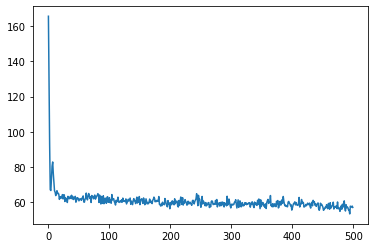

In [95]:
plt.plot(history.history["loss"])

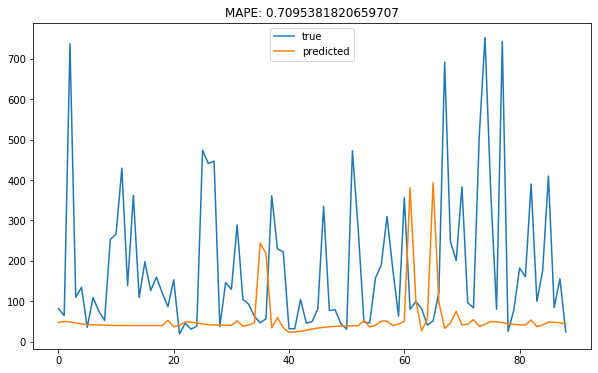

In [96]:
make_prediction(lstm_conv, data_for_time_series, 30, test_index, x_test)

# После многочисленых испытаний - лучшая модель == rnn

In [97]:
data_for_time_series = data_for_time_series.sort_index()

In [98]:
data_for_time_series.head()

,min
time_start,
2018-01-01 04:35:56,472.383333
2018-01-01 19:30:47,31.516667
2018-01-02 16:11:12,14.116667
2018-01-23 14:55:41,34.816667
2018-01-26 16:01:02,52.516667


In [100]:
test_size = 0.1
test_index = int(len(data_for_time_series) * (1-test_size))

data_for_time_series = data_for_time_series.reset_index(drop=True)

x_train = data_for_time_series.loc[:test_index]['min']
x_test = data_for_time_series.loc[test_index:]['min']
    
x_test = x_test.reset_index()

x_test = x_test.drop(columns=['index'])

In [107]:
tf.keras.backend.clear_session()

train_dataset = make_datasets(x_train, batch_size=200, window_size=40)
test_dataset = make_datasets(x_test, batch_size=200, window_size=40)

rnn = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                         SimpleRNN(32, return_sequences=True),
                         SimpleRNN(16),
                         Dense(8, activation='relu'),
                         Dense(1), 
                         Lambda(lambda x : x * 500.0)])

optimizer = tf.keras.optimizers.Adam()
rnn.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer)

In [108]:
history = rnn.fit(train_dataset, epochs=500)

Train on None steps
Epoch 1/500
2/2 [==============================]ss: 93.654 - 1s 283ms/step - loss: 78.463 - 1s 286ms/step - loss: 78.4633
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 82.79 - 0s 49ms/step - loss: 78.8195
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 62.90 - 0s 41ms/step - loss: 61.1413
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 66.18 - 0s 43ms/step - loss: 70.5507
Epoch 5/500
2/2 [==============================] - ETA: 0s - loss: 64.17 - 0s 43ms/step - loss: 61.7279
Epoch 6/500
2/2 [==============================] - ETA: 0s - loss: 61.92 - 0s 50ms/step - loss: 62.3253
Epoch 7/500
2/2 [==============================] - ETA: 0s - loss: 62.79 - 0s 51ms/step - loss: 69.2698
Epoch 8/500
2/2 [==============================] - ETA: 0s - loss: 60.56 - 0s 49ms/step - loss: 64.7210
Epoch 9/500
2/2 [==============================] - ETA: 0s - loss: 60.61 - 0s 51ms/step - loss: 63.6322
Epoch 10/500
2/2 [========

Epoch 79/500
2/2 [==============================] - ETA: 0s - loss: 59.25 - 0s 53ms/step - loss: 56.2844
Epoch 80/500
2/2 [==============================] - ETA: 0s - loss: 58.79 - 0s 77ms/step - loss: 55.7655
Epoch 81/500
2/2 [==============================] - ETA: 0s - loss: 59.84 - 0s 65ms/step - loss: 56.3603
Epoch 82/500
2/2 [==============================] - ETA: 0s - loss: 59.44 - 0s 55ms/step - loss: 61.9673
Epoch 83/500
2/2 [==============================] - ETA: 0s - loss: 58.28 - 0s 59ms/step - loss: 56.6853
Epoch 84/500
2/2 [==============================] - ETA: 0s - loss: 59.87 - 0s 65ms/step - loss: 59.0598
Epoch 85/500
2/2 [==============================] - ETA: 0s - loss: 61.40 - 0s 64ms/step - loss: 54.6525
Epoch 86/500
2/2 [==============================] - ETA: 0s - loss: 58.76 - 0s 80ms/step - loss: 56.8264
Epoch 87/500
2/2 [==============================] - ETA: 0s - loss: 57.70 - 0s 74ms/step - loss: 61.3518
Epoch 88/500
2/2 [==============================] - ETA

2/2 [==============================] - ETA: 0s - loss: 59.11 - 0s 53ms/step - loss: 61.6870
Epoch 157/500
2/2 [==============================] - ETA: 0s - loss: 56.62 - 0s 95ms/step - loss: 62.8043
Epoch 158/500
2/2 [==============================] - ETA: 0s - loss: 60.00 - 0s 92ms/step - loss: 53.2069
Epoch 159/500
2/2 [==============================] - ETA: 0s - loss: 59.68 - 0s 59ms/step - loss: 54.0006
Epoch 160/500
2/2 [==============================] - ETA: 0s - loss: 56.91 - 0s 56ms/step - loss: 60.3811
Epoch 161/500
2/2 [==============================] - ETA: 0s - loss: 56.15 - 0s 40ms/step - loss: 62.7957
Epoch 162/500
2/2 [==============================] - ETA: 0s - loss: 58.03 - 0s 40ms/step - loss: 56.4455
Epoch 163/500
2/2 [==============================] - ETA: 0s - loss: 56.80 - 0s 81ms/step - loss: 60.9342
Epoch 164/500
2/2 [==============================] - ETA: 0s - loss: 56.28 - 0s 92ms/step - loss: 62.5204
Epoch 165/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 56.90 - 0s 78ms/step - loss: 58.3986
Epoch 234/500
2/2 [==============================] - ETA: 0s - loss: 56.72 - 0s 55ms/step - loss: 59.3112
Epoch 235/500
2/2 [==============================] - ETA: 0s - loss: 57.71 - 0s 54ms/step - loss: 55.3519
Epoch 236/500
2/2 [==============================] - ETA: 0s - loss: 57.74 - 0s 84ms/step - loss: 56.9030
Epoch 237/500
2/2 [==============================] - ETA: 0s - loss: 58.16 - 0s 72ms/step - loss: 55.7523
Epoch 238/500
2/2 [==============================] - ETA: 0s - loss: 57.13 - 0s 78ms/step - loss: 57.3003
Epoch 239/500
2/2 [==============================] - ETA: 0s - loss: 56.98 - 0s 73ms/step - loss: 57.8707
Epoch 240/500
2/2 [==============================] - ETA: 0s - loss: 57.16 - 0s 74ms/step - loss: 57.7245
Epoch 241/500
2/2 [==============================] - ETA: 0s - loss: 57.61 - 0s 75ms/step - loss: 55.9798
Epoch 242/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 60.19 - 0s 85ms/step - loss: 59.3092
Epoch 311/500
2/2 [==============================] - ETA: 0s - loss: 56.00 - 0s 46ms/step - loss: 63.9060
Epoch 312/500
2/2 [==============================] - ETA: 0s - loss: 59.74 - 0s 37ms/step - loss: 61.2329
Epoch 313/500
2/2 [==============================] - ETA: 0s - loss: 59.63 - 0s 37ms/step - loss: 63.1727
Epoch 314/500
2/2 [==============================] - ETA: 0s - loss: 58.96 - 0s 54ms/step - loss: 57.0037
Epoch 315/500
2/2 [==============================] - ETA: 0s - loss: 61.97 - 0s 48ms/step - loss: 61.8326
Epoch 316/500
2/2 [==============================] - ETA: 0s - loss: 58.31 - 0s 47ms/step - loss: 56.1369
Epoch 317/500
2/2 [==============================] - ETA: 0s - loss: 60.98 - 0s 70ms/step - loss: 65.9914
Epoch 318/500
2/2 [==============================] - ETA: 0s - loss: 65.26 - 0s 73ms/step - loss: 60.2855
Epoch 319/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 60.06 - 0s 73ms/step - loss: 58.1995
Epoch 388/500
2/2 [==============================] - ETA: 0s - loss: 59.16 - 0s 70ms/step - loss: 62.1143
Epoch 389/500
2/2 [==============================] - ETA: 0s - loss: 57.87 - 0s 80ms/step - loss: 58.1085
Epoch 390/500
2/2 [==============================] - ETA: 0s - loss: 57.41 - 0s 88ms/step - loss: 61.0201
Epoch 391/500
2/2 [==============================] - ETA: 0s - loss: 57.13 - 0s 87ms/step - loss: 54.6620
Epoch 392/500
2/2 [==============================] - ETA: 0s - loss: 58.26 - 0s 82ms/step - loss: 52.2111
Epoch 393/500
2/2 [==============================] - ETA: 0s - loss: 56.79 - 0s 89ms/step - loss: 54.8726
Epoch 394/500
2/2 [==============================] - ETA: 0s - loss: 57.91 - 0s 81ms/step - loss: 58.6607
Epoch 395/500
2/2 [==============================] - ETA: 0s - loss: 54.91 - 0s 62ms/step - loss: 63.8313
Epoch 396/500
2/2 [==============================] - ETA: 0s

2/2 [==============================] - ETA: 0s - loss: 58.74 - 0s 68ms/step - loss: 62.5680
Epoch 465/500
2/2 [==============================] - ETA: 0s - loss: 62.05 - 0s 45ms/step - loss: 67.6428
Epoch 466/500
2/2 [==============================] - ETA: 0s - loss: 58.10 - 0s 49ms/step - loss: 53.1507
Epoch 467/500
2/2 [==============================] - ETA: 0s - loss: 63.06 - 0s 68ms/step - loss: 63.4063
Epoch 468/500
2/2 [==============================] - ETA: 0s - loss: 59.01 - 0s 68ms/step - loss: 55.9971
Epoch 469/500
2/2 [==============================] - ETA: 0s - loss: 59.17 - 0s 58ms/step - loss: 57.8747
Epoch 470/500
2/2 [==============================] - ETA: 0s - loss: 64.78 - 0s 61ms/step - loss: 56.8136
Epoch 471/500
2/2 [==============================] - ETA: 0s - loss: 61.09 - 0s 62ms/step - loss: 58.5581
Epoch 472/500
2/2 [==============================] - ETA: 0s - loss: 57.16 - 0s 90ms/step - loss: 57.3619
Epoch 473/500
2/2 [==============================] - ETA: 0s

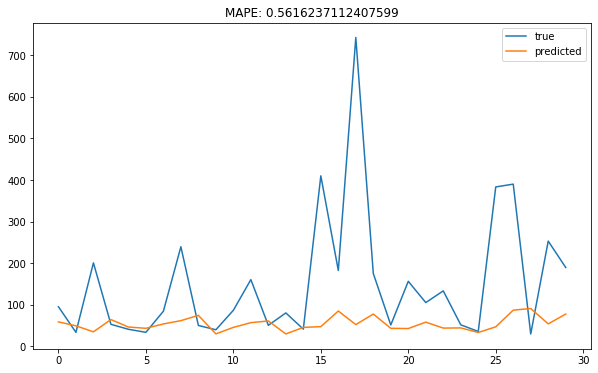

In [110]:
make_prediction(rnn, data_for_time_series, 40, test_index, x_test)

# Модель довольно странно подогналась под MAPE, но зато это лучшее, что получилось. Что важно, она довольно устойчива и не склонна к переобучению. Главный недостаток - отсутсвие смелых прогнозов, но это позволяет выдовать приемлемый MAPE.